In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from pandas.io.json._normalize import nested_to_record

%matplotlib inline

In [2]:
username = "lavender"
project_name = "new_age_performance"
metric_name = "eval/roc_auc"
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(f"{username}/{project_name}")
summary_list = []
config_list = []
name_list = []
for run in runs:
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # run.config is the input metrics.
    # We remove special values that start with _.
    conf = nested_to_record(run.config, sep="/")
    config = {k: v for k, v in conf.items() if not k.startswith("_")}
    config_list.append(config)

    # run.name is the name of the run.
    name_list.append(run.name)

import pandas as pd

summary_df = pd.DataFrame.from_records(summary_list)
config_df = pd.DataFrame.from_records(config_list)
name_df = pd.DataFrame({"name": name_list})
data_df = pd.concat([name_df, config_df, summary_df], axis=1)

data_df.to_csv("data/age_eval.csv")

In [3]:
import numpy as np

plot_df = data_df[["name", metric_name]]
plot_df.name = pd.Categorical(
    plot_df.name,
    categories=[f"age_{y}_to_{y+10}" for y in np.arange(0, 90, 10)],
    ordered=True,
)
plot_df = plot_df.sort_values(by="name", ascending=True)
plot_df["legend"] = plot_df.name.apply(lambda x: " ".join(x.split("_")))
plot_df

/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_6605/1999820993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.name = pd.Categorical(plot_df.name,


,name,eval/roc_auc,legend
8,age_0_to_10,0.779233,age 0 to 10
7,age_10_to_20,0.808624,age 10 to 20
6,age_20_to_30,0.843403,age 20 to 30
5,age_30_to_40,0.843591,age 30 to 40
4,age_40_to_50,0.790956,age 40 to 50
3,age_50_to_60,0.768945,age 50 to 60
2,age_60_to_70,0.755856,age 60 to 70
1,age_70_to_80,0.728617,age 70 to 80
0,age_80_to_90,0.683996,age 80 to 90


In [27]:
plot_df["count"] = [9612, 10662, 14706, 22465, 26545, 31293, 38077, 45534, 51324]
plot_df["p"] = [
    0.033083645443196,
    0.037703995498030385,
    0.04453964368285054,
    0.04727353661250835,
    0.05643247315878697,
    0.06924871376985269,
    0.08472306116553299,
    0.09878332674485,
    0.10778583119008651,
]
plot_df["readmission_rate"] = plot_df["p"].apply(lambda x: f"{100*x:10.2f}%")
plot_df

,name,eval/roc_auc,legend,count,read_rate,p,readmission_rate
8,age_0_to_10,0.779233,age 0 to 10,9612,0.033084,0.033084,3.31%
7,age_10_to_20,0.808624,age 10 to 20,10662,0.037704,0.037704,3.77%
6,age_20_to_30,0.843403,age 20 to 30,14706,0.044540,0.044540,4.45%
5,age_30_to_40,0.843591,age 30 to 40,22465,0.047274,0.047274,4.73%
4,age_40_to_50,0.790956,age 40 to 50,26545,0.056432,0.056432,5.64%
3,age_50_to_60,0.768945,age 50 to 60,31293,0.069249,0.069249,6.92%
2,age_60_to_70,0.755856,age 60 to 70,38077,0.084723,0.084723,8.47%
1,age_70_to_80,0.728617,age 70 to 80,45534,0.098783,0.098783,9.88%
0,age_80_to_90,0.683996,age 80 to 90,51324,0.107786,0.107786,10.78%


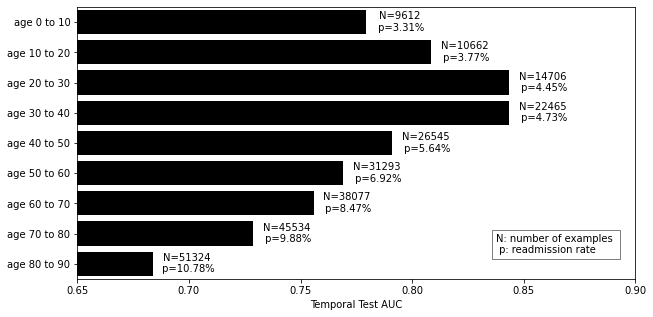

In [34]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=plot_df, y="legend", x=metric_name, color="black", orient="h")
for idx, p in enumerate(ax.patches):
    ax.annotate(
        "N="
        + str(plot_df.iloc[idx]["count"])
        + "\n p="
        + plot_df.iloc[idx]["readmission_rate"].strip(),
        (p.get_width() + 0.015, p.get_y() + 0.75),
        ha="center",
        va="bottom",
        color="black",
    )
t = plt.text(
    0.75,
    0.1,
    "N: number of examples \n p: readmission rate",
    wrap=True,
    transform=plt.gca().transAxes,
)
t.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="black"))
plt.xlabel("Temporal Test AUC")
plt.ylabel("")
plt.xlim([0.65, 0.9])
plt.savefig("plots/age_analysis.png", dpi=300, bbox_inches="tight")